### Imports

In [25]:
import numpy as np
import pandas as pd

from utils.data_loader import load_csv,custom_tokenizer, transform_input, extract_pos_features

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn import svm

from scipy.sparse import hstack
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve, confusion_matrix, ConfusionMatrixDisplay


### Load Dataset & Util Initialization

In [ ]:
lex_scores = []

texts, labels, lex_scores = load_csv('data/dreaddit-train-spellchecked-lex.csv')

# Uncomment for training without lexicon scores
# texts, labels = load_csv('data/dreaddit-train-spellchecked.csv', lexicon=False)

# The tool used to Tokenize and calculate the samples' Tfidf
vectorizer_params = {
    # "stop_words": "english",      # SKLearn's default stopword removal
    "min_df": 3,                    # min no. of documents allowed
    "max_df": 0.2,                  # max % of documents allowed 
    "max_features": 3000,           # retains X best performing tokens
    "ngram_range":(1,3),            # 1 token can be 1-3 words
    "tokenizer": custom_tokenizer   # custom regex & stemming
}

vectorizer = TfidfVectorizer(**vectorizer_params)
scaler = MinMaxScaler()

### K-Fold Validation

In [3]:
# Uses default K-Fold validation (n=5 -> 80/20)
kf = KFold()

# Multinomial NB, Logistic Regression as fast, interpretable models
# SVC and XGBoost for non-linear feature relationships
models = { 
          "Multinomial NB": {"clf": MultinomialNB(), "scores": []},
          "Logistic Regression" : {"clf": LogisticRegression(C=0.3), "scores": []},
          # "SVC" : {"clf": svm.SVC(kernel='rbf', probability=True), "scores": []},
          "XGBoost" : {"clf": XGBClassifier(n_estimators=200,
                              learning_rate=0.05,
                              max_depth=4,
                              gamma=2,
                              subsample=0.8,
                              colsample_bytree=0.8), "scores": []}
          }


for train_ids, val_ids in kf.split(texts):

    # Retrieves the corresponding samples based on the k-fold split
    X_train_texts = [texts[i] for i in train_ids]
    X_val_texts = [texts[i] for i in val_ids]
    y_train = [labels[i] for i in train_ids]
    y_val = [labels[i] for i in val_ids]
    
    
    X_train = vectorizer.fit_transform(X_train_texts)
    X_val = vectorizer.transform(X_val_texts)
    

    if any(lex_scores):

      X_train_avg_lex_scores = np.array([lex_scores[i] for i in train_ids]).reshape(-1,1)
      X_val_avg_lex_scores = np.array([lex_scores[i] for i in val_ids]).reshape(-1,1)

      
      X_train_lex_scores = scaler.fit_transform(X_train_avg_lex_scores.reshape(-1, 1))
      X_val_lex_scores = scaler.transform(X_val_avg_lex_scores.reshape(-1,1))

      X_train = hstack([X_train, X_train_lex_scores])
      X_val = hstack([X_val, X_val_lex_scores])

    
      X_train = pd.DataFrame(X_train.toarray(), columns=np.append(vectorizer.get_feature_names_out(),"lexicon_score"))
      X_val = pd.DataFrame(X_val.toarray(), columns=np.append(vectorizer.get_feature_names_out(),"lexicon_score"))

    for model_name, model in models.items():
        clf = model['clf'].fit(X_train, y_train)
        y_pred = clf.predict(X_val)
        y_score = clf.predict_proba(X_val)
        model['scores'].append(f1_score(y_val, y_pred, average='macro'))

    #     model['y_scores'] = (y_score)

        
    ## ROC Curves for every validation fold
  
    # plt.figure(figsize=(10, 7))
    # for model_name, model in models.items():
    #     fpr, tpr, _ = roc_curve(y_val,model['y_scores'][:,1])
    #     roc_auc = auc(fpr, tpr)

    #     plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

    # plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    # plt.xlim([0.0, 1.0])
    # plt.ylim([0.0, 1.05])
    # plt.xlabel('False Positive Rate')
    # plt.ylabel('True Positive Rate')
    # plt.title('ROC Curves for Models')
    # plt.legend(loc='lower right')
    # plt.show()

/home/achilleas/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/achilleas/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/achilleas/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/achilleas/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/achilleas/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


### Calculate Score Means and Variances

In [4]:
df_data = {'Classifier': [], 'Mean':[], "Variance":[], "Scores":[]}
for model_name, model in models.items():
    mean = np.mean(model['scores'])
    var = np.var(model['scores'])

    df_data['Classifier'].append(model_name)
    df_data['Mean'].append(mean)
    df_data['Variance'].append(var)
    df_data['Scores'].append(model['scores'])
    
scores_df = pd.DataFrame(df_data)
print(scores_df)

with open('scores.txt','a') as f:
    f.write(f"\n\n{vectorizer_params}")
    f.write(f"\n{scores_df.to_string()}")

            Classifier      Mean  Variance  \
0       Multinomial NB  0.759195  0.000317   
1  Logistic Regression  0.766354  0.000255   
2              XGBoost  0.724950  0.000512   

                                              Scores  
0  [0.7305707346690953, 0.7609539396773439, 0.763...  
1  [0.7417396512419137, 0.7687634213118779, 0.774...  
2  [0.6934987320609235, 0.7288429823800018, 0.742...  


### Boxplot

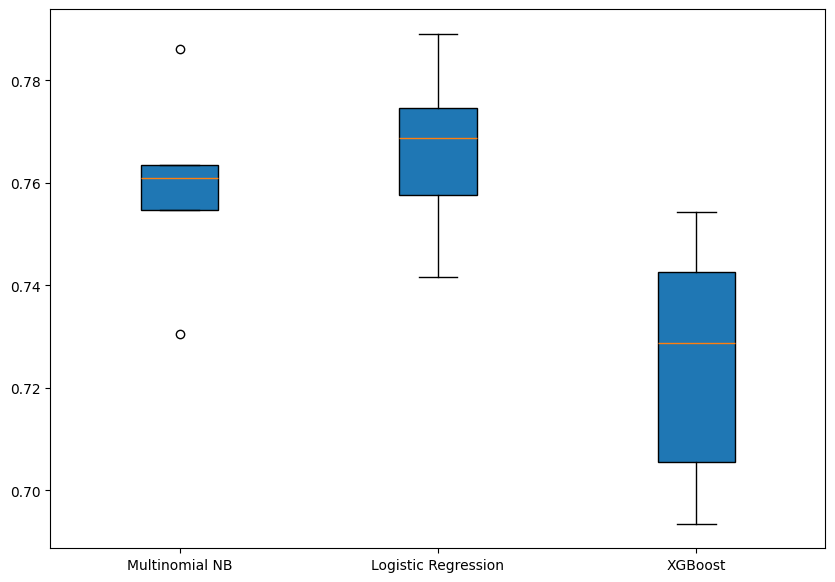

In [6]:
scores = []
plot_labels = []

fig = plt.figure(figsize=(10,7))
for model_name, model in models.items():
    scores.append(model['scores'])
    plot_labels.append(model_name)
    
plt.boxplot(scores,patch_artist=True,tick_labels=plot_labels)
plt.show()

### Print each model's feature importance estimations

In [12]:
xgboost_feature_scores = models['XGBoost']['clf'].get_booster().get_score(importance_type='total_gain')
xgb_df = pd.DataFrame(list(xgboost_feature_scores.items()), columns=["Token", "Score"]).sort_values("Score", ascending=False)
print("XGBOOST")
print("-------------------")
print(xgb_df[0:10])
print()

feature_names = vectorizer.get_feature_names_out()
importance = models['Logistic Regression']['clf'].coef_[0]  # Coefficients per feature

feature_names = np.append(feature_names,'lexicon_score')
top_features = pd.DataFrame({"Word": feature_names, "Weight": importance}).sort_values("Weight", ascending=False)
print("LOGISTIC REGRESSION")
print("-------------------")
print(top_features[0:10])
print()

log_prob = models['Multinomial NB']['clf'].feature_log_prob_
nb_features = pd.DataFrame({"Token": feature_names, "Class 0":log_prob[0], "Class 1": log_prob[1]}).sort_values(by="Class 1", ascending=False)
print("MULTINOMIAL NB")
print("-------------------")
print(nb_features[0:10])


XGBOOST
-------------------
             Token        Score
424  lexicon_score  2273.345947
147         i feel   447.758698
392        what to   338.634979
55           can't   331.600067
423           your   291.164307
63           curli   255.475723
417           year   255.020966
141        i can't   214.470047
24         anxieti   203.941895
87            even   202.562851

LOGISTIC REGRESSION
-------------------
               Word    Weight
3000  lexicon_score  3.236294
454           can't  1.009662
1160         i feel  0.982473
1132        i can't  0.928476
86               am  0.880283
195         anxieti  0.862615
708            even  0.835805
1149        i don't  0.799607
1753         myself  0.782448
772       feel like  0.749089

MULTINOMIAL NB
-------------------
              Token   Class 0   Class 1
3000  lexicon_score -2.793311 -2.761588
86               am -6.697230 -6.130477
1149        i don't -6.894083 -6.225690
1121           i am -6.788949 -6.267829
2749         

### Training

In [24]:
texts, y_train, train_lex_scores = load_csv('data/dreaddit-train-spellchecked-lex.csv')
test_texts, y_test, test_lex_scores = load_csv("./data/dreaddit-test-spellchecked-lex.csv")

# Uncomment for training without lexicon scores
# texts, labels = load_csv('data/dreaddit-train-spellchecked.csv', lexicon=False)
# test_texts, y_test = load_csv("./data/dreaddit-test-spellchecked.csv", lexicon=False)

models = { 
          "Multinomial NB": {"clf": MultinomialNB()},
          "Logistic Regression" : {"clf": LogisticRegression(C=0.3),},
          "SVC" : {"clf": svm.SVC(kernel='rbf', probability=True)},
          "XGBoost" : {"clf": XGBClassifier(n_estimators=200,
                              learning_rate=0.05,
                              max_depth=4,
                              gamma=2,
                              subsample=0.8,
                              colsample_bytree=0.8)}
          }

X_train = vectorizer.fit_transform(texts)
X_test = vectorizer.transform(test_texts)


if any(lex_scores):

    X_train_avg_lex_scores = train_lex_scores
    X_test_avg_lex_scores = test_lex_scores
    
    X_train_lex_scores = scaler.fit_transform(X_train_avg_lex_scores.reshape(-1, 1))
    X_test_lex_scores = scaler.transform(X_test_avg_lex_scores.reshape(-1,1))

    X_train = hstack([X_train, X_train_lex_scores])
    X_test = hstack([X_test, X_test_lex_scores])


    X_train = pd.DataFrame(X_train.toarray(), columns=np.append(vectorizer.get_feature_names_out(),"lexicon_score"))
    X_test = pd.DataFrame(X_test.toarray(), columns=np.append(vectorizer.get_feature_names_out(),"lexicon_score"))

for model_name, model in models.items():
    clf = model['clf'].fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_score = clf.predict_proba(X_test)
    model['y_pred'] = y_pred
    model['y_score'] = y_score
    model['f1_score'] = f1_score(y_test, y_pred, average='macro')

/home/achilleas/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [22]:
df_data = {'Classifier': [], "f1_score":[]}
for model_name, model in models.items():
    df_data['Classifier'].append(model_name)
    df_data['f1_score'].append(model['f1_score'])
    
scores_df = pd.DataFrame(df_data)
print(scores_df)


            Classifier  f1_score
0       Multinomial NB  0.724594
1  Logistic Regression  0.754974
2                  SVC  0.757310
3              XGBoost  0.732051


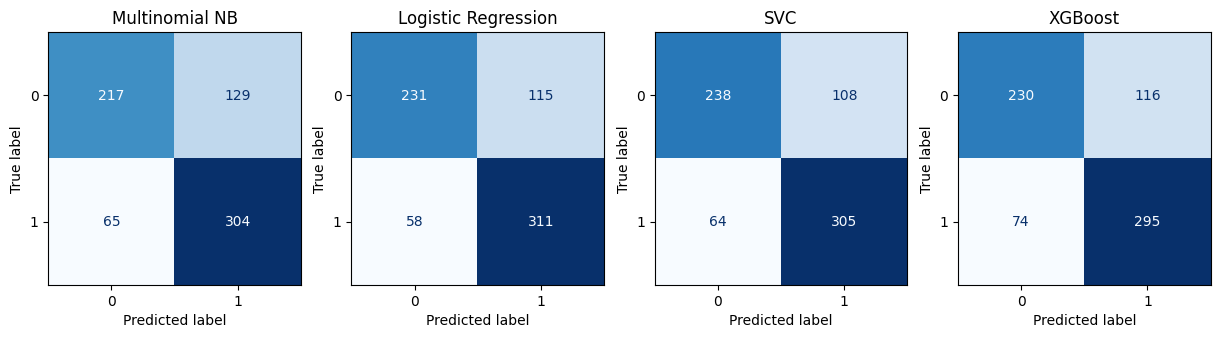

In [26]:
confusion_matrices = {}

for model_name, model in models.items():
    confusion_matrices[model_name] = confusion_matrix(y_test,model['y_pred'])

fig, axes = plt.subplots(1, 4, figsize=(15, 5))
axes= axes.flatten()
for i, (name,cm) in enumerate(confusion_matrices.items()):
    subplot = ConfusionMatrixDisplay(cm)
    axes[i].set_title(name)
    subplot.plot(ax=axes[i], cmap='Blues', colorbar=False)

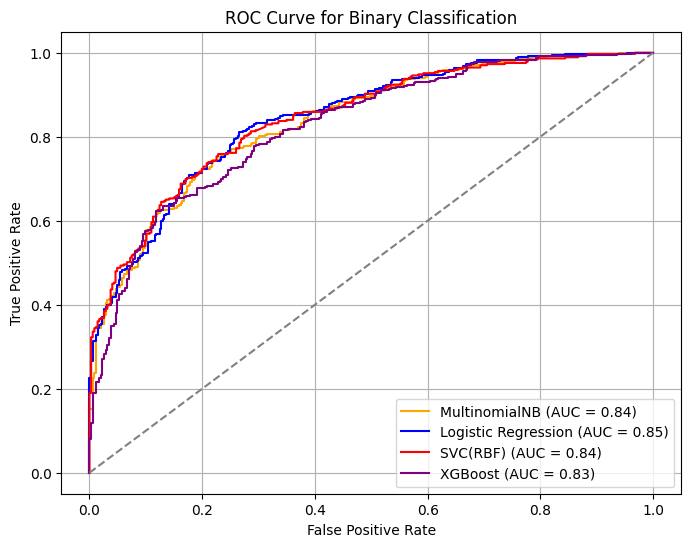

In [30]:
# Convert labels to one-hot encoding (required for ROC-AUC computation)
fpr = []
tpr = []
roc_auc = []

for model_name, model in models.items():
    m_fpr, m_tpr, _ = roc_curve(y_test,model['y_score'][:,1])
    m_roc_auc = auc(m_fpr,m_tpr)
    fpr.append(m_fpr)
    tpr.append(m_tpr)
    roc_auc.append(m_roc_auc)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr[0],tpr[0], label=f'MultinomialNB (AUC = {roc_auc[0]:.2f})', color = 'orange')
plt.plot(fpr[1], tpr[1], label=f'Logistic Regression (AUC = {roc_auc[1]:.2f})', color='blue')
plt.plot(fpr[2],tpr[2], label=f'SVC(RBF) (AUC = {roc_auc[2]:.2f})', color = 'red')
plt.plot(fpr[3],tpr[3], label=f'XGBoost (AUC = {roc_auc[3]:.2f})', color = 'purple')
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Random guess line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Binary Classification")
plt.legend()
plt.grid()
plt.show()

In [ ]:
df_data = {'Classifier': [], 'Mean':[], "Variance":[], "Scores":[]}
for model_name, model in models.items():
    mean = np.mean(model['scores'])
    var = np.var(model['scores'])

    df_data['Classifier'].append(model_name)
    df_data['Mean'].append(mean)
    df_data['Variance'].append(var)
    df_data['Scores'].append(model['scores'])
    
scores_df = pd.DataFrame(df_data)
print(scores_df)

with open('scores.txt','a') as f:
    f.write(f"\n\n{vectorizer_params}")
    f.write(f"\n{scores_df.to_string()}")

            Classifier      Mean  Variance  \
0       Multinomial NB  0.759195  0.000317   
1  Logistic Regression  0.766354  0.000255   
2              XGBoost  0.724950  0.000512   

                                              Scores  
0  [0.7305707346690953, 0.7609539396773439, 0.763...  
1  [0.7417396512419137, 0.7687634213118779, 0.774...  
2  [0.6934987320609235, 0.7288429823800018, 0.742...  


In [27]:
inference_text = "Today I went for a walk in the park. it was Amazing!. I feel very happy and I can't wait to go tomorrow as well."
# inference_text = "I am very stressed and I have anxiety."
input = transform_input(inference_text,vectorizer,scaler)

print(models['Multinomial NB']['clf'].predict(input))
print(models['Multinomial NB']['clf'].predict_proba(input))

print(models['Logistic Regression']['clf'].predict(input))
print(models['Logistic Regression']['clf'].predict_proba(input))

print(models['SVC']['clf'].predict(input))
print(models['SVC']['clf'].predict_proba(input))

print(models['XGBoost']['clf'].predict(input))
print(models['XGBoost']['clf'].predict_proba(input))

print(custom_tokenizer(inference_text))



[1]
[[0.33339767 0.66660233]]
[1]
[[0.47104617 0.52895383]]
[1]
[[0.47600382 0.52399618]]
[1]
[[0.4949094 0.5050906]]
['today', 'i', 'went', 'for', 'walk', 'in', 'the', 'park', 'it', 'wa', 'amaz', 'i', 'feel', 'veri', 'happi', 'and', 'i', "can't", 'wait', 'to', 'go', 'tomorrow', 'as', 'well']
